# Chipotle Customer Segmentation:  Unsupervised Learning Algorthim - K-Means Clustering Survey Analysis

Shayan Golshan

sgolshan2018@gmail.com

## Introduction

In this notebook, I will be analyzing Chipotle's customer survey data to identify customer segments. To identify the segments, the method of K-Means clustering will be utilized.  The data was collected from a series of customer surveys that captured information on what their favorite fast food chains were, what they valued in a fast food resturant, as well as their income, and demographic information.  These insights can be used for Chipotle's marketing strategies, menu optimizations, and customer experience enhancement.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np

## Read in and Clean Survey Data

In [36]:
survey_data = pd.read_excel('Data/survey_data_chipotle.xlsx')
survey_data.head()


,top1,wom,sm,walk,billboard,patronage,importantconvenience,importantvariety,importantprice,importanthealthy,...,chipotlehealthy,chipotletaste,chipotleambience,female,age,income,plan,spending,buylocal,healthyimportanttome
0,In-n-out,0,0,1,0,0,5.0,4.0,5.0,5.0,...,5.0,5.0,4.0,0.0,52.0,20942.0,3.0,3.0,2.0,1.0
1,Chick-Fil-A,0,0,1,0,1,5.0,3.0,5.0,2.0,...,4.0,4.0,4.0,0.0,35.0,24330.0,3.0,2.0,NaN,3.0
2,Chipotle,1,0,0,0,0,5.0,5.0,5.0,5.0,...,4.0,3.0,4.0,0.0,37.0,41052.0,2.0,2.0,2.0,2.0
3,Chipotle,0,0,1,0,0,5.0,4.0,5.0,5.0,...,5.0,5.0,5.0,0.0,33.0,86277.0,2.0,3.0,2.0,2.0
4,Panera,0,0,0,0,2,4.0,4.0,5.0,5.0,...,4.0,4.0,3.0,0.0,49.0,54651.0,1.0,4.0,2.0,2.0


In [37]:
# Check the Shape of the Data
survey_data.shape

(357, 25)

After looking at the shape, we can see that there are 357 rows and 25 columns.  This is consistent with the documentation that there were over 300 survey responses.

In [38]:
# Check the Data Types
print(survey_data.info())
survey_data['income'] = pd.to_numeric(survey_data['income'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   top1                  357 non-null    object 
 1   wom                   357 non-null    int64  
 2   sm                    357 non-null    int64  
 3   walk                  357 non-null    int64  
 4   billboard             357 non-null    int64  
 5   patronage             357 non-null    int64  
 6   importantconvenience  338 non-null    float64
 7   importantvariety      333 non-null    float64
 8   importantprice        334 non-null    float64
 9   importanthealthy      335 non-null    float64
 10  importanttaste        332 non-null    float64
 11  importantambience     335 non-null    float64
 12  chipotleconvenient    334 non-null    float64
 13  chipotlevariety       333 non-null    float64
 14  chipotleprice         336 non-null    float64
 15  chipotlehealthy       3

top1                     0
wom                      0
sm                       0
walk                     0
billboard                0
patronage                0
importantconvenience    19
importantvariety        24
importantprice          23
importanthealthy        22
importanttaste          25
importantambience       22
chipotleconvenient      23
chipotlevariety         24
chipotleprice           21
chipotlehealthy         27
chipotletaste           23
chipotleambience        24
female                  14
age                     14
income                  14
plan                    14
spending                16
buylocal                17
healthyimportanttome    16
dtype: int64


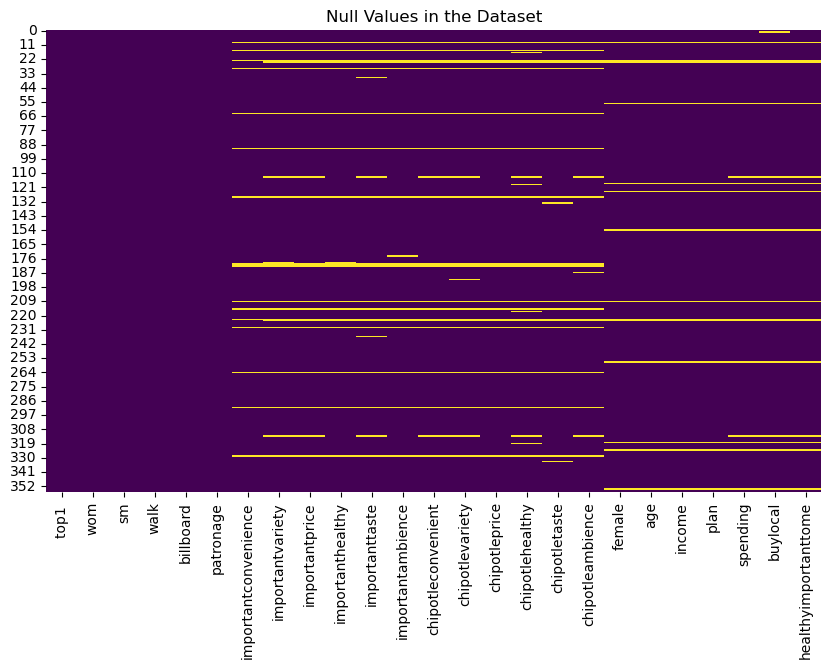

In [39]:
# Check for Missing Values
print(survey_data.isnull().sum())

# Visualize the Missing Values
plt.figure(figsize=(10, 6))
sns.heatmap(survey_data.isnull(), cbar=False, cmap='viridis')
plt.title('Null Values in the Dataset')
plt.show()

In the above heatmap, you can see that there were a decent amount of missing values (represented by the yellow bars) in the survey data.  In dropping this data, we lose a lot of valuable information, however, we can still get a good idea of what the customer segments are like by omitting the missing values.

In [40]:
# Drop the Missing Values
survey_data.dropna(inplace=True)

In [41]:
# Check the Shape once again
survey_data.shape

(313, 25)

Here you can see that we only lost around 44 observations, which isn't too bad and we can continue with our cluster analysis.

Let's now check the top1 column to see how many unique names there are.  Since Customers inputted the names of their favorite fast food resturants, there will be variation in the names and we will have to clean this up a bit.

In [42]:
# Printing the unique values in top1 column and make alphabetical order
survey_data['top1 '] = survey_data['top1 '].str.lower().str.strip()
pd.Series(survey_data['top1 '].unique()).sort_values()

8               applebees
7                   arbys
29            burger king
18            chick fil a
13             chick fila
3             chick-fil-a
23              chickfila
14             chik-fil-a
31                chipole
4                chipolte
1                chipotle
16          el pollo loco
11                 eppies
0                in-n-out
10    in-n-out kebob shop
28           jason's deli
30            jasons deli
5                     kfc
22             macdonalds
6               mcdonalds
9                 outback
2                  panera
17           panera bread
12          pizza express
27              pizza hut
15              starbucks
19                sub way
25                 subway
24              taco bell
26             the market
21                wendy's
20                 wendys
dtype: object

Now that we have the restuarant names, we can use Regex to clean up the names and make them more uniform.

In [43]:
# Clean the top1 column and replace variations of restaurant names with a standard name
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)chic?k[-_ ]?fil[-_ ]?[aA]', "Chick-fil-A", regex=True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)chip?o?l?t?l?e', "Chipotle", regex= True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)panera', "Panera", regex=True)
survey_data['top1 '] = survey_data['top1 '].str.replace(r'(?i)s[u\W]*b[u\W]*w[a\W]*y', "Subway", regex=True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)starbucks', "Starbucks", regex=True)
survey_data['top1 '] = survey_data['top1 '].str.replace("(?i)wendy'?s", "Wendy's", regex= True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)burger[-_ ]?king', "Burger King", regex=True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)five[-_ ]?guys', "Five Guys", regex=True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)kfc', "KFC", regex=True)
survey_data['top1 '] = survey_data['top1 '].str.replace("(?i)arby'?s", "Arby's", regex= True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)applebees', "Applebee's", regex=True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)in[-_ ]?n[-_ ]?out', "In-N-Out", regex=True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)in[-_ ]?n[-_ ]?out[-_ ]?kebob[-_ ]?shop', "In-N-Out", regex=True)
survey_data['top1 '] = survey_data['top1 '].str.replace("(?i)jason'?s\s?deli", "Jason's Deli", regex= True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)ma?cdonald[-_ ]?[sS]', "McDonald's", regex= True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)outback', "Outback", regex=True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)pizza express', "Pizza Express", regex=True)
survey_data['top1 '] = survey_data['top1 '].str.replace('(?i)pizza hut', "Pizza Hut", regex=True)

# Capitalize the first letter of each word in the top1 column
survey_data['top1 '] = survey_data['top1 '].str.capitalize()

In [44]:
pd.Series(survey_data['top1 '].unique()).sort_values()

7        Applebee's
6            Arby's
20      Burger king
3       Chick-fil-a
1          Chipotle
12    El pollo loco
9            Eppies
0          In-n-out
19     Jason's deli
4               Kfc
5        Mcdonald's
8           Outback
2            Panera
13     Panera bread
10    Pizza express
18        Pizza hut
11        Starbucks
14           Subway
16        Taco bell
17       The market
15          Wendy's
dtype: object

Now that we have done this, we will use a label enconder in order to make these string values numeric for later clustering use.

In [45]:
label_encoder = LabelEncoder()
survey_data['top1 encoded'] = label_encoder.fit_transform(survey_data['top1 '])
survey_data.head()

,top1,wom,sm,walk,billboard,patronage,importantconvenience,importantvariety,importantprice,importanthealthy,...,chipotletaste,chipotleambience,female,age,income,plan,spending,buylocal,healthyimportanttome,top1 encoded
0,In-n-out,0,0,1,0,0,5.0,4.0,5.0,5.0,...,5.0,4.0,0.0,52.0,20942.0,3.0,3.0,2.0,1.0,7
2,Chipotle,1,0,0,0,0,5.0,5.0,5.0,5.0,...,3.0,4.0,0.0,37.0,41052.0,2.0,2.0,2.0,2.0,4
3,Chipotle,0,0,1,0,0,5.0,4.0,5.0,5.0,...,5.0,5.0,0.0,33.0,86277.0,2.0,3.0,2.0,2.0,4
4,Panera,0,0,0,0,2,4.0,4.0,5.0,5.0,...,4.0,3.0,0.0,49.0,54651.0,1.0,4.0,2.0,2.0,12
5,Chick-fil-a,1,0,0,0,0,5.0,4.0,4.0,4.0,...,4.0,4.0,0.0,21.0,58742.0,2.0,4.0,2.0,2.0,3


Now lets look at the statistical summary of our data

In [46]:
survey_data.describe()

,wom,sm,walk,billboard,patronage,importantconvenience,importantvariety,importantprice,importanthealthy,importanttaste,...,chipotletaste,chipotleambience,female,age,income,plan,spending,buylocal,healthyimportanttome,top1 encoded
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,...,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,0.568690,0.076677,0.332268,0.012780,0.402556,4.495208,4.297125,4.670927,4.546326,4.929712,...,4.367412,3.766773,0.214058,40.290735,41123.990415,1.833866,2.971246,1.824281,1.670927,8.316294
std,0.496052,0.266505,0.471781,0.112502,1.036633,0.641120,0.691912,0.563601,0.634425,0.256040,...,0.761130,0.916331,0.410824,12.230498,21078.031002,0.787240,0.951957,0.727957,0.691305,4.578968
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,4.000000,...,2.000000,2.000000,0.000000,18.000000,10157.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,4.000000,5.000000,...,4.000000,3.000000,0.000000,33.000000,24582.000000,1.000000,2.000000,1.000000,1.000000,5.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,5.000000,4.000000,5.000000,5.000000,5.000000,...,5.000000,4.000000,0.000000,38.000000,38160.000000,2.000000,3.000000,2.000000,2.000000,7.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,0.000000,49.000000,53955.000000,2.000000,4.000000,2.000000,2.000000,12.000000
max,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,1.000000,73.000000,89076.000000,5.000000,5.000000,5.000000,5.000000,20.000000


## Exploratory Data Analysis

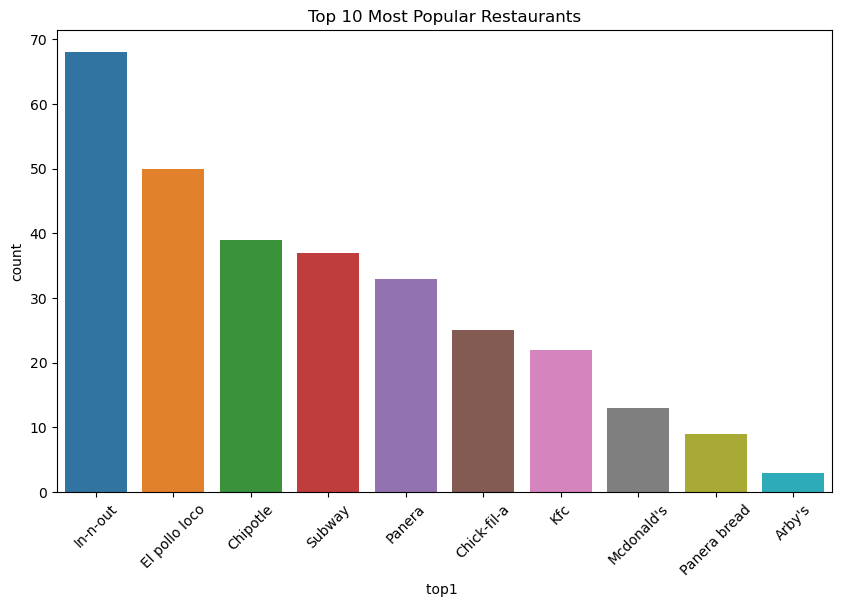

In [47]:
# Plot the top 10 most popular restaurants
plt.figure(figsize=(10, 6))
sns.countplot(x='top1 ', data=survey_data, order=survey_data['top1 '].value_counts().iloc[:10].index)
plt.title('Top 10 Most Popular Restaurants')
plt.xticks(rotation=45)
plt.show()

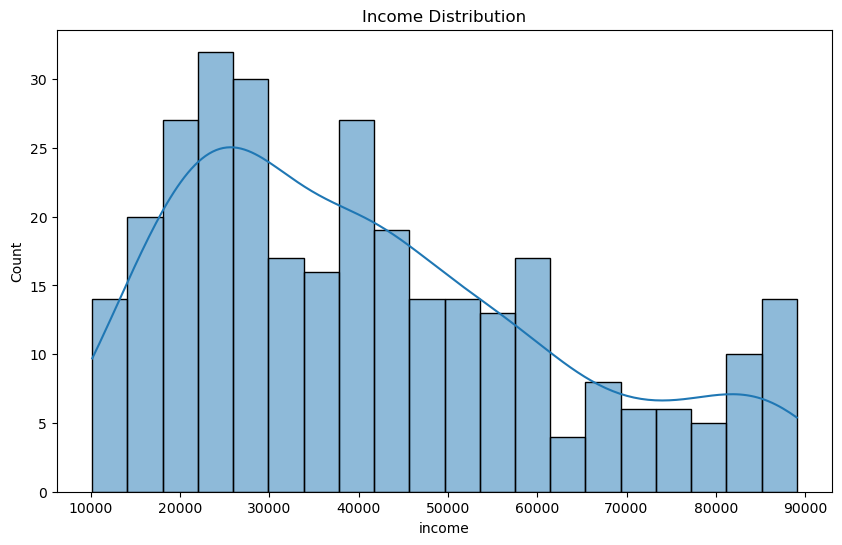

In [48]:
# Income Distribution
plt.figure(figsize=(10, 6))
sns.histplot(survey_data['income'], bins = 20, kde=True)
plt.title('Income Distribution')
plt.show()

From this histogram, we can see that the income of the individuals is positively (right) skewed meaning that the mean overestimates the most common values.  The mean income will typically be higher than the median income because few high income individuals (closer to $90K income) pull the mean to the right.  

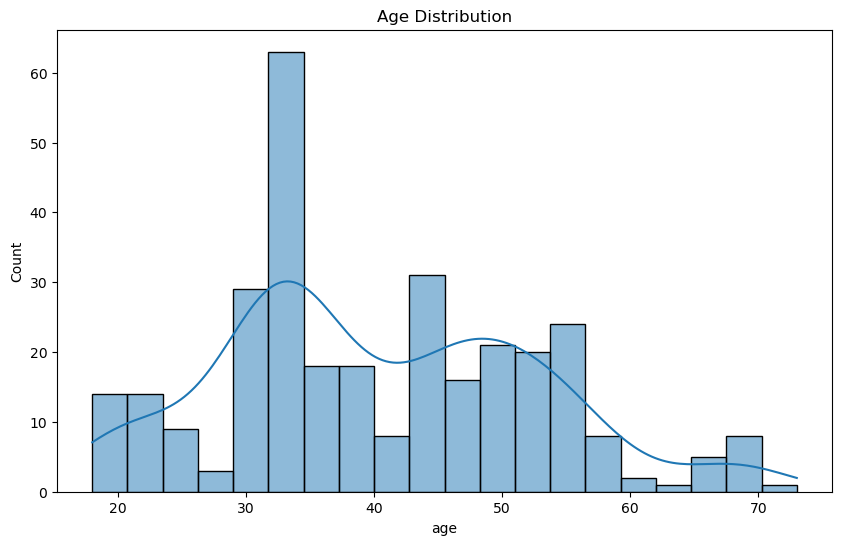

In [49]:
# Distribution of the Age Variable
plt.figure(figsize=(10, 6))
sns.histplot(survey_data['age'], bins = 20, kde=True)
plt.title('Age Distribution')
plt.show()

With the age distribution, it is also positively skewed, however, it is not as severe as the income plot.

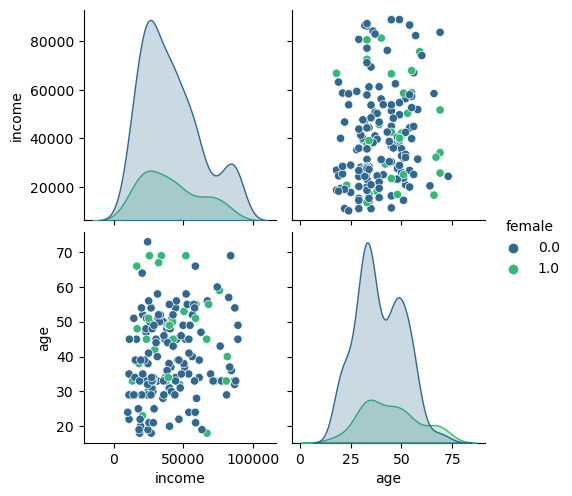

In [50]:
# Pairplot of the Data
sns.pairplot(survey_data, vars = ['income', 'age'], hue = 'female', palette='viridis')
plt.show()

## K-Means Cluster Model for Post-Processed Survey Data

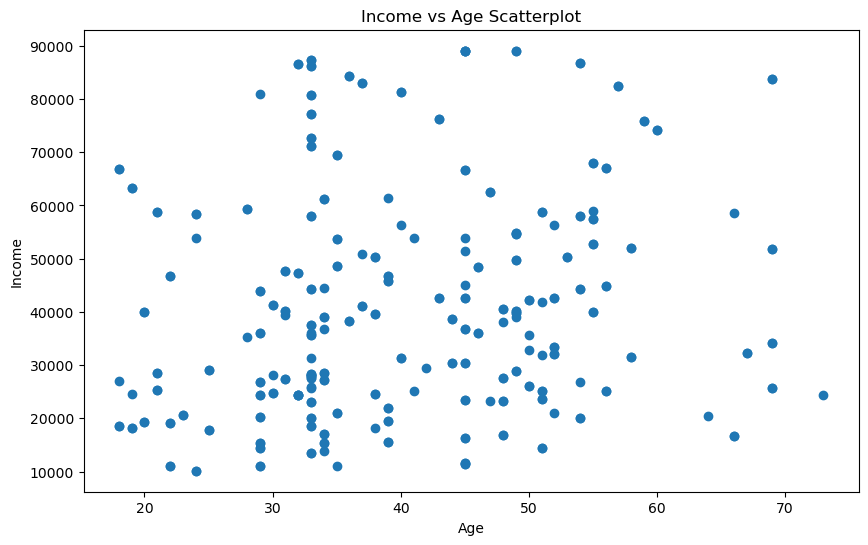

In [51]:
plt.figure(figsize=(10, 6))
plt.title('Income vs Age Scatterplot')
plt.xlabel('Age')
plt.ylabel('Income')
plt.scatter(x = 'age', y = 'income', data = survey_data)
plt.show()

In [52]:
# drop the top1 column since it has strings and we already have the label encoded version
survey_data.drop('top1 ', axis=1, inplace=True)

In [53]:
# K Means Model
kmeans = KMeans(n_clusters= 4)
kmeans.fit(survey_data)

# Add cluster labels to the original DataFrame
survey_data['cluster'] = kmeans.labels_
survey_data['cluster'].value_counts().sort_index()

c:\Users\Shayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Shayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0    127
1     58
2     89
3     39
Name: cluster, dtype: int64

Here are our Clusters Visualized

<Axes: xlabel='age', ylabel='income'>

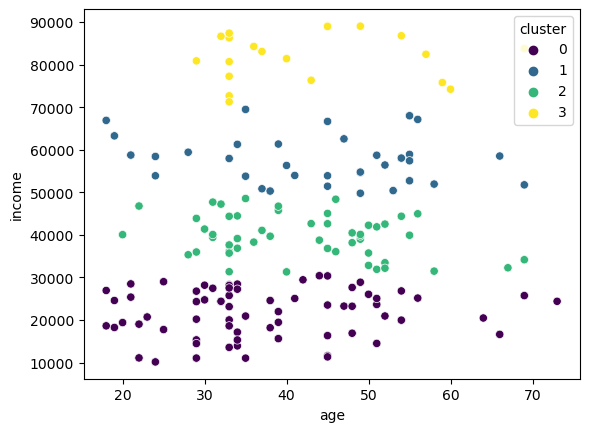

In [54]:
sns.scatterplot(x='age', y='income', data=survey_data, hue='cluster', palette='viridis')

In [55]:
clusters = survey_data.groupby('cluster').mean().sort_values(by='cluster')
clusters

,wom,sm,walk,billboard,patronage,importantconvenience,importantvariety,importantprice,importanthealthy,importanttaste,...,chipotletaste,chipotleambience,female,age,income,plan,spending,buylocal,healthyimportanttome,top1 encoded
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.614173,0.125984,0.322835,0.031496,0.220472,4.622047,4.409449,4.732283,4.645669,4.889764,...,4.488189,4.015748,0.212598,36.937008,21706.007874,1.803150,2.779528,1.905512,1.748031,8.566929
1,0.413793,0.034483,0.344828,0.000000,0.517241,4.396552,4.224138,4.637931,4.517241,4.965517,...,4.362069,3.568966,0.224138,43.172414,57984.948276,1.741379,3.068966,1.775862,1.551724,8.517241
2,0.662921,0.000000,0.303371,0.000000,0.651685,4.539326,4.303371,4.831461,4.561798,4.955056,...,4.235955,3.741573,0.213483,42.011236,39963.168539,1.820225,3.000000,1.764045,1.662921,8.056180
3,0.435897,0.153846,0.410256,0.000000,0.256410,4.128205,4.025641,4.153846,4.230769,4.948718,...,4.282051,3.307692,0.205128,43.000000,81930.692308,2.102564,3.384615,1.769231,1.615385,7.794872


## Demographics of the 4 Clusters

In [56]:
clusters[['age', 'female', 'income']]

,age,female,income
cluster,,,
0,36.937008,0.212598,21706.007874
1,43.172414,0.224138,57984.948276
2,42.011236,0.213483,39963.168539
3,43.000000,0.205128,81930.692308


## What each Cluster finds Important in a Restaurant

In [57]:
importance = clusters[['importantconvenience', 'importantvariety', 'importantprice', 'importanthealthy', 'importanttaste']]
importance

,importantconvenience,importantvariety,importantprice,importanthealthy,importanttaste
cluster,,,,,
0,4.622047,4.409449,4.732283,4.645669,4.889764
1,4.396552,4.224138,4.637931,4.517241,4.965517
2,4.539326,4.303371,4.831461,4.561798,4.955056
3,4.128205,4.025641,4.153846,4.230769,4.948718


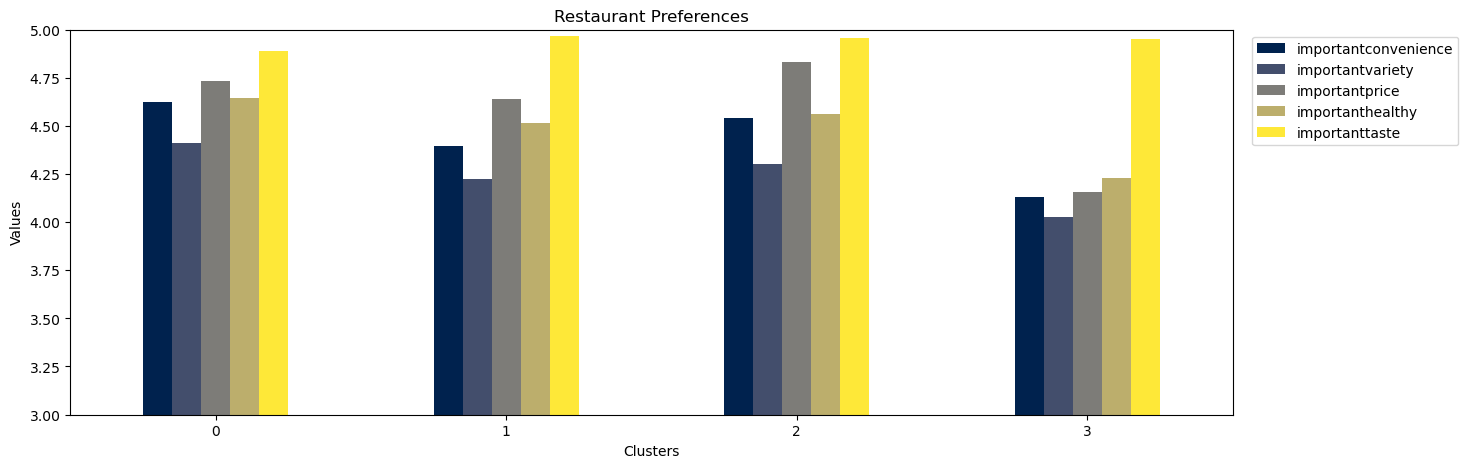

In [58]:
importance.iloc[:,0:6].plot(kind='bar', figsize=(15,5), title='Restaurant Preferences',  colormap='cividis')
plt.xticks(rotation=1)
plt.xlabel('Clusters')
plt.ylabel('Values')
plt.ylim(3, 5)
plt.legend( loc='upper right', bbox_to_anchor=(1.2, 1))

## Chipotle Expectations for Each Cluster

In [59]:
chipotle_expectations = clusters[['chipotleconvenient', 'chipotlevariety', 'chipotleprice', 'chipotlehealthy', 'chipotletaste']]
chipotle_expectations

,chipotleconvenient,chipotlevariety,chipotleprice,chipotlehealthy,chipotletaste
cluster,,,,,
0,4.015748,3.874016,3.661417,4.464567,4.488189
1,3.775862,3.931034,3.413793,4.465517,4.362069
2,3.674157,3.786517,3.662921,4.505618,4.235955
3,3.384615,3.564103,3.358974,4.333333,4.282051


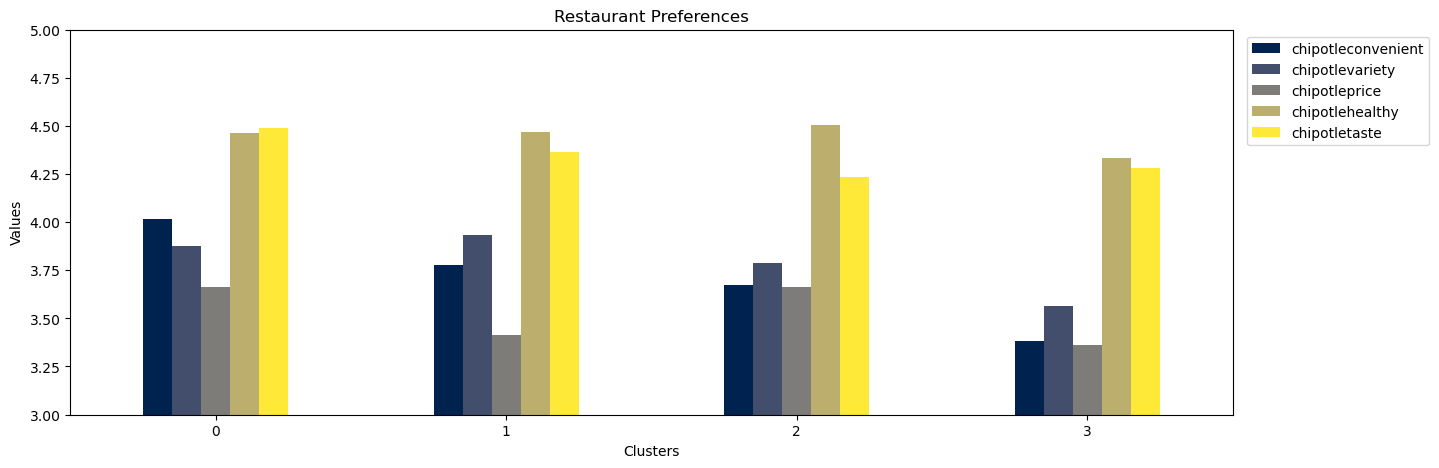

In [60]:
chipotle_expectations.iloc[:, 0:5].plot(kind='bar', figsize=(15,5), title='Restaurant Preferences',  colormap='cividis')
plt.xticks(rotation=1)
plt.xlabel('Clusters')
plt.ylabel('Values')
plt.ylim(3, 5)
plt.legend( loc='upper right', bbox_to_anchor=(1.175, 1))

## Cluster Breakdown

**Cluster 0:**  *Average Age 36.9370, Average Income $21,706.01*

This can be classified as the Budget-Conscious Variety Seekers.  For what they value in a restaurant, they ranked convenience, variety, price, health, and taste at 4.6220, 4.4094, 4.7323. 4.6457, and 4.8898, respectively.  When it comes to the expectations for Chipotle, cluster 0 valued convenince (4.0157), variety (3.8740), and price (3.6614) less than healthy (4.4646) and taste (4.4882).  Since this is the lowest income and youngest group here, they place a high value on price and health when it comes to a restaurant.  

**Cluster 1:**  *Average Age 43.1724, Average Income $57,984.95*

This can be classified as the Middle-High Income Taste Focused.  This cluster has the lowest values for how they rank importance of a restaurant and only care about how the product tastes (4.9655).  This is also consistent when carried over to the Chipotle expecations as taste is the second highest ranking (4.36206) behind healthy (4.465517).

**Cluster 2:**  *Average Age 42.01, Average Income $39,963.17*

For this cluster, we can classify them as the Middle-Low Income Health Conscious Individuals.  This cluster values price, health, and taste the most out with values of 4.8315, 4.5618, and 4.9551, respectively.  

**Cluster 3:**  *Average Age 43, Average Income $81,930.69*

For our final cluster, these individuals can be classified as the High Income Taste Focused individuals.  Based off the values from what they value in a restaurant, it can be inferred that they prioritize only taste (4.9487) when dining at a restaurant, relative to the other clusters.  As far as Chipotle expectations go, they have the lowest expectations for a convenience (3.3846), variety (3.5641), and price (3.3590).  For Chipotle, they only are focused on the health and price aspects of the chain.  



# Recommendations:

**Cluster 0 - Budget-Conscious Variety Seekers**
- Chipotle should emphasize its value menu and affordable options in its marketing campaigns.
- Highlight the healthiness of menu items, showcasing low-cost, nutritious choices.
- Promote variety and customization options, allowing customers to build their meals within budget constraints.

**Cluster 1 - Middle-High Income Taste Focused**
- Chipotle can focus on marketing its taste and flavor profiles, highlighting the quality and uniqueness of its ingredients.
- Emphasize the gourmet and artisanal aspects of the menu to appeal to those seeking a tasteful dining experience.
- Consider limited-time, premium offerings to cater to the taste-focused preferences of this group.

**Cluster 2 - Middle-Low Income Health Conscious Individuals**
- Chipotle can market itself as a health-conscious fast-food option with a range of nutritious choices.
- Promote its commitment to using fresh and natural ingredients, which align with the health-conscious values of this group.
- Emphasize affordability without compromising on healthiness to attract this segment.

**Cluster 3 - Budget-Conscious Variety Seekers**
- Chipotle should highlight its premium ingredients and the gourmet appeal of its menu items in its marketing.
- Target this group with upscale branding and imagery to align with their taste-focused preferences.
- Offer exclusive taste-driven promotions or partnerships with high-end chefs to attract this segment.